# Imports

In [44]:
import sys
print(sys.executable)

c:\Users\reinm\anaconda3\envs\precursor_legacy\python.exe


Number of threads to use

In [45]:
import os
os.environ["OMP_NUM_THREADS"] = '15' # set cores for numpy
os.environ['TF_INTER_OP_PARALLELISM_THREADS'] = '15' # set cores for TF
os.environ['TF_INTRA_OP_PARALLELISM_THREADS'] = '15'

Configure TensorFlow

In [46]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow logs
print(tf.__version__)

2.10.0


Remaining imports

In [47]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
from pathlib import Path

# Data Handling

Data loading

In [48]:
# Data is generated from Gen_data.ipynb. 
# ATTENTION: Get the data from Teams! File is too large to upload to GitHub
fln = "Generated_data.h5"
hf  = h5py.File(fln,'r')

# Check the contents of the HDF5 file
print("Contents of the HDF5 file:", list(hf.keys()))

Contents of the HDF5 file: ['dissipation_rates', 'kinetic_energy', 'velocity_field']


Initializing the velocity field 

In [49]:
downsample = 5 # Skip every n-th sample to get varying data. Otherwise the data is to similar and large. Set to 1 to use all data.
Re = 30
data_len = 12000
transient = 200 # Number of transient steps to ignore from our data

# Load the velocity field
U = np.array(hf.get('velocity_field')[transient:transient+data_len:downsample], dtype=np.float32)
total_samples = U.shape[0]
hf.close()

# Check the length of the velocity field
print("Shape of the velocity field:", U.shape)  
print(f"So, the velocity field has {total_samples} samples, each sample has 48x48 grid points and each grid point has 2 components (ux,uy)")

# Define the number of grid points in x and y directions
N_x     = U.shape[1] 
N_y     = U.shape[2]

Shape of the velocity field: (2400, 48, 48, 2)
So, the velocity field has 2400 samples, each sample has 48x48 grid points and each grid point has 2 components (ux,uy)


Splitting the data into train, validation and test sets, and batching the data

In [50]:
b_size = 50   #batch_size
n_batches = total_samples//b_size  #number of batches

# Split the data into training, validation and test sets with 70%, 15% and 15% of the data respectively
train_batches = int(n_batches*(4/6))
val_batches = int(n_batches*(1/6))
test_batches = int(n_batches*(1/6))

print(f"Number of batches: {n_batches}, Train batches: {train_batches}, Validation batches: {val_batches}, Test batches: {test_batches}")

Number of batches: 48, Train batches: 32, Validation batches: 8, Test batches: 8


In [51]:
def batch_data(U, b_size, n_batches):
    
    '''
    Splits the data in batches. Each batch is created by sampling the signal with interval
    equal to n_batches
    '''
    data = np.zeros((n_batches, b_size, U.shape[1], U.shape[2], U.shape[3]))    
    for i in range(n_batches):
        data[i] = U[i::n_batches].copy()

    return data

In [52]:
# training data
U_train_unbatched = np.array(U[:train_batches*b_size].copy())
print("Shape of the training data before batching:", U_train_unbatched.shape)
U_train = batch_data(U_train_unbatched, b_size, train_batches).astype('float32') # to be used for randomly shuffled batches
print("Shape of the training data after batching:", U_train.shape, "\n")

# validation data
U_val_unbatched = np.array(U[train_batches*b_size:train_batches*b_size+b_size*val_batches].copy())
print("Shape of the validation data before batching:", U_val_unbatched.shape)
U_val = batch_data(U_val_unbatched, b_size, val_batches).astype('float32')         
print("Shape of the validation data after batching:", U_val.shape, "\n")

# test data
U_test_unbatched = np.array(U[train_batches*b_size+b_size*val_batches:].copy())
print("Shape of the test data before batching:", U_test_unbatched.shape)
U_test = batch_data(U_test_unbatched, b_size, test_batches).astype('float32')
print("Shape of the test data after batching:", U_test.shape)

# Delete the original data to save memory:
del U_train_unbatched, U_val_unbatched

Shape of the training data before batching: (1600, 48, 48, 2)
Shape of the training data after batching: (32, 50, 48, 48, 2) 

Shape of the validation data before batching: (400, 48, 48, 2)
Shape of the validation data after batching: (8, 50, 48, 48, 2) 

Shape of the test data before batching: (400, 48, 48, 2)
Shape of the test data after batching: (8, 50, 48, 48, 2)


# Autoencoder Functions

In [53]:
'''
Changes: included loss mse and optimizer as inputs to train_step
'''
#@tf.function #this creates the tf graph
def model(inputs, enc_mods, dec_mods, is_train=False):
    
    '''
    Multiscale autoencoder, taken from Hasegawa 2020. The contribution of the CNNs at different
    scales are simply summed.
    '''
        
    # sum of the contributions of the different CNNs
    encoded = 0
    for enc_mod in enc_mods:
        encoded += enc_mod(inputs, training=is_train)
            
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=is_train)
        
    return encoded, decoded


#@tf.function #this creates the tf graph
def train_step(inputs, enc_mods, dec_mods, Loss_Mse, optimizer, train=True):
    
    """
    Trains the model by minimizing the loss between input and output
    """
    
    # autoencoded field
    decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]

    # loss with respect to the data
    loss = Loss_Mse(inputs, decoded)
    
    # compute and apply gradients inside tf.function environment for computational efficiency
    if train:
        # create a variable with all the weights to perform gradient descent on
        # appending lists is done by plus sign
        varss = [] #+ Dense.trainable_weights
        for enc_mod in enc_mods:
            varss  += enc_mod.trainable_weights
        for dec_mod in dec_mods:
            varss +=  dec_mod.trainable_weights
        
        with tf.GradientTape() as tape:
            decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]
            loss = Loss_Mse(inputs, decoded)
        grads = tape.gradient(loss, varss)
        optimizer.apply_gradients(zip(grads, varss))
    
    return loss


In [54]:
def periodic_padding(image, padding=1, asym=False):
    '''
    Create a periodic padding (same of np.pad('wrap')) around the image, 
    to mimic periodic boundary conditions.
    When asym=True on the right and lower edges an additional column/row is added
    '''
        
    if asym:
        lower_pad = image[:,:padding+1,:]
    else:
        lower_pad = image[:,:padding,:]
    
    if padding != 0:
        upper_pad     = image[:,-padding:,:]
        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)
    else:
        partial_image = tf.concat([image, lower_pad], axis=1)
        
    if asym:
        right_pad = partial_image[:,:,:padding+1] 
    else:
        right_pad = partial_image[:,:,:padding]
    
    if padding != 0:
        left_pad = partial_image[:,:,-padding:]
        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
    else:
        padded_image = tf.concat([partial_image, right_pad], axis=2)

    return padded_image

In [55]:
class PerPad2D(tf.keras.layers.Layer):
    """
    Periodic Padding layer
    """
    def __init__(self, padding=1, asym=False, **kwargs):
        self.padding = padding
        self.asym    = asym
        super(PerPad2D, self).__init__(**kwargs)
        
    def get_config(self): #needed to be able to save and load the model with this layer
        config = super(PerPad2D, self).get_config()
        config.update({
            'padding': self.padding,
            'asym': self.asym,
        })
        return config

    def call(self, x):
        return periodic_padding(x, self.padding, self.asym)

# Create the Model

In [56]:
'''
TODO: hyperparameter tuning
'''

## define the model
# we do not have pooling and upsampling, instead we use stride=2
N_lat         = 5                          # change N_lat hyperparameter
last_conv_dep = 1                          #output depth of last conv layer, if we want to include dissipation rate and vorticity, increase this number
n_fil         = [6,12,24,last_conv_dep]          #number of filters encoder
n_dec         = [24,12,6,3]                #number of filters decoder
N_parallel    = 3                          #number of parallel CNNs for multiscale
ker_size      = [(3,3), (5,5), (7,7)]      #kernel sizes
N_layers      = 4                          #number of layers in every CNN
act           = 'tanh'                     #activation function

pad_enc       = 'valid'         #no padding in the conv layer
pad_dec       = 'valid'
p_size        = [0,1,2]         #stride = 2 periodic padding size          
p_fin         = [1,2,3]         #stride = 1 periodic padding size
p_dec         = 1               #padding in the first decoder layer
p_crop        = U.shape[1]      #crop size of the output equal to input size


In [57]:
#initialize the encoders and decoders with different kernel sizes    
enc_mods      = [None]*(N_parallel)
dec_mods      = [None]*(N_parallel)    
for i in range(N_parallel):
    enc_mods[i] = tf.keras.Sequential(name='Enc_' + str(i))
    dec_mods[i] = tf.keras.Sequential(name='Dec_' + str(i))

In [58]:
#generate encoder layers    
for j in range(N_parallel):
    for i in range(N_layers):      

        #stride=2 padding and conv
        enc_mods[j].add(PerPad2D(padding=p_size[j], asym=True,
                                          name='Enc_' + str(j)+'_PerPad_'+str(i)))
        enc_mods[j].add(tf.keras.layers.Conv2D(filters = n_fil[i], kernel_size=ker_size[j],
                                      activation=act, padding=pad_enc, strides=2,
                        name='Enc_' + str(j)+'_ConvLayer_'+str(i)))

        #stride=1 padding and conv
        if i<N_layers-1:
            enc_mods[j].add(PerPad2D(padding=p_fin[j], asym=False,
                                                      name='Enc_'+str(j)+'_Add_PerPad1_'+str(i)))
            enc_mods[j].add(tf.keras.layers.Conv2D(filters=n_fil[i],
                                                    kernel_size=ker_size[j], 
                                                activation=act,padding=pad_dec,strides=1,
                                                    name='Enc_'+str(j)+'_Add_Layer1_'+str(i)))  
    # Add fully connected layer
    enc_mods[j].add(tf.keras.layers.Flatten(name='Enc_' + str(j) + '_Flatten'))
    enc_mods[j].add(tf.keras.layers.Dense(N_lat, activation='linear', name='Enc_' + str(j) + '_Dense'))

In [59]:
#explicitly obtain the size of the latent space
output = U_train[0]
for i, layer in enumerate(enc_mods[-1].layers):
    output = layer(output)  # Forward pass through the current layer
    if i == (N_layers - 1) * 4 + 1:  # Stop after the 4th layer (index 3)
        conv_out_shape = output.shape[1:]
        conv_out_size = np.prod(conv_out_shape)
        print("Output shape of the last convolutional layer:", conv_out_shape)
        print("SIze of last convolutional output: ", conv_out_size)
    elif i == (N_layers - 1) * 4 + 2 + 1:
         print("Size of the latent space:", output.shape[-1])  

Output shape of the last convolutional layer: (3, 3, 1)
SIze of last convolutional output:  9
Size of the latent space: 5


In [60]:
_#generate decoder layers            
for j in range(N_parallel):
    
    # Add fully connected layer first to map latent space to the appropriate dimensions
    dec_mods[j].add(tf.keras.layers.Dense(conv_out_size, activation='linear', name='Dec_' + str(j) + '_Dense'))
    dec_mods[j].add(tf.keras.layers.Reshape(conv_out_shape, name='Dec_' + str(j) + '_Reshape'))


    for i in range(N_layers):

        #initial padding of latent space
        if i==0: 
            dec_mods[j].add(PerPad2D(padding=p_dec, asym=False,
                                          name='Dec_' + str(j)+'_PerPad_'+str(i))) 
        
        #Transpose convolution with stride = 2 
        dec_mods[j].add(tf.keras.layers.Conv2DTranspose(filters = n_dec[i],
                                       output_padding=None,kernel_size=ker_size[j],
                                      activation=act, padding=pad_dec, strides=2,
                            name='Dec_' + str(j)+'_ConvLayer_'+str(i)))
        
        #Convolution with stride=1
        if  i<N_layers-1:       
            dec_mods[j].add(tf.keras.layers.Conv2D(filters=n_dec[i],
                                        kernel_size=ker_size[j], 
                                       activation=act,padding=pad_dec,strides=1,
                                      name='Dec_' + str(j)+'_ConvLayer1_'+str(i)))

    #crop and final linear convolution with stride=1
    dec_mods[j].add(tf.keras.layers.CenterCrop(p_crop + 2*p_fin[j],
                                                   p_crop+ 2*p_fin[j],
                            name='Dec_' + str(j)+'_Crop_'+str(i)))
    dec_mods[j].add(tf.keras.layers.Conv2D(filters=U.shape[3],
                                            kernel_size=ker_size[j], 
                                            activation='linear',padding=pad_dec,strides=1,
                                              name='Dec_' + str(j)+'_Final_Layer'))

In [61]:
# run the model once to print summary
enc0, dec0 = model(U_train[0], enc_mods, dec_mods)
print('latent space size:', N_lat)
print('physical space size:', U[0].flatten().shape)
print('')
for j in range(3):
    enc_mods[j].summary()
for j in range(3):
    dec_mods[j].summary()

latent space size: 5
physical space size: (4608,)

Model: "Enc_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Enc_0_PerPad_0 (PerPad2D)   (50, 49, 49, 2)           0         
                                                                 
 Enc_0_ConvLayer_0 (Conv2D)  (50, 24, 24, 6)           114       
                                                                 
 Enc_0_Add_PerPad1_0 (PerPad  (50, 26, 26, 6)          0         
 2D)                                                             
                                                                 
 Enc_0_Add_Layer1_0 (Conv2D)  (50, 24, 24, 6)          330       
                                                                 
 Enc_0_PerPad_1 (PerPad2D)   (50, 25, 25, 6)           0         
                                                                 
 Enc_0_ConvLayer_1 (Conv2D)  (50, 12, 12, 12)          660       
          

# Train the Model

In [62]:
n_epochs = 50
rng = np.random.default_rng() # random generator for later shuffling

#define loss, optimizer and initial learning rate   
Loss_Mse    = tf.keras.losses.MeanSquaredError()
optimizer   = tf.keras.optimizers.Adam(amsgrad=True) #amsgrad True for better convergence
l_rate      = 0.002
optimizer.learning_rate = l_rate

# quantities to check and store the training and validation loss and the training goes on
old_loss      = np.zeros(n_epochs) #needed to evaluate training loss convergence to update l_rate
tloss_plot    = np.zeros(n_epochs)      # training loss
vloss_plot    = np.zeros(n_epochs)      # validation loss
N_check       = 1                       # each N_check epochs we check convergence and validation loss
patience      = 10                       # if the val_loss has not gone down in the last patience epochs, early stop
last_save     = patience               # last epoch where the model was saved

# Hyperparameters for changing learning rate
N_lr = 2
lrate_update = True
lrate_mult = 0.75

N_plot = 5

In [65]:
def save_model(path):
    print('Saving Model..')
    model_path = path
    Path(model_path).mkdir(parents=True, exist_ok=True) #creates directory even when it exists
    for i in range(N_parallel):
        enc_mods[i].save(model_path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5')
        dec_mods[i].save(model_path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5')
        enc_mods[i].save_weights(model_path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')
        dec_mods[i].save_weights(model_path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')

def save_optimizer_params(path, optimizer):
    min_weights = optimizer.get_weights()
    hf = h5py.File(path + '/opt_weights.h5','w')
    for i in range(len(min_weights)):
        hf.create_dataset('weights_'+str(i),data=min_weights[i])
    hf.create_dataset('length', data=i)
    hf.create_dataset('l_rate', data=optimizer.learning_rate)  
    hf.close()

def load_model(path):
    print('LOADING MINIMUM')
    model_path = path
    for i in range(N_parallel):
        enc_mods[i].load_weights(model_path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')
        dec_mods[i].load_weights(model_path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')

def plot_training_curve(): 
    plt.rcParams["figure.figsize"] = (15,4)
    plt.rcParams["font.size"]  = 20
    plt.title('MSE convergence')
    plt.yscale('log')
    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
    plt.plot(tloss_plot[np.nonzero(tloss_plot)], 'y', label='Train loss')
    plt.plot(np.arange(np.nonzero(vloss_plot)[0].shape[0])*N_check,
                vloss_plot[np.nonzero(vloss_plot)], label='Val loss')
    plt.xlabel('epochs')
    plt.legend()    
    plt.tight_layout()
    plt.show()

Epochs:   2%|▏         | 1/50 [00:13<11:06, 13.61s/it]

Epoch 0 ; Train_Loss 0.0744 ; Val_Loss 0.0840 ; Ratio 1.1292
Time per epoch 13.61 seconds



Epochs:   4%|▍         | 2/50 [00:27<10:55, 13.65s/it]

Epoch 1 ; Train_Loss 0.0705 ; Val_Loss 0.0896 ; Ratio 1.2705
Time per epoch 13.68 seconds



Epochs:   6%|▌         | 3/50 [00:56<16:09, 20.62s/it]

Epoch 2 ; Train_Loss 0.0686 ; Val_Loss 0.0902 ; Ratio 1.3150
Time per epoch 28.92 seconds



Epochs:   8%|▊         | 4/50 [01:12<14:25, 18.81s/it]

Epoch 3 ; Train_Loss 0.0668 ; Val_Loss 0.0896 ; Ratio 1.3428
Time per epoch 16.03 seconds



Epochs:  10%|█         | 5/50 [01:27<13:16, 17.69s/it]

Epoch 4 ; Train_Loss 0.0634 ; Val_Loss 0.0927 ; Ratio 1.4607
Time per epoch 15.72 seconds

Epoch 5 ; Train_Loss 0.0619 ; Val_Loss 0.0932 ; Ratio 1.5055
Time per epoch 16.12 seconds



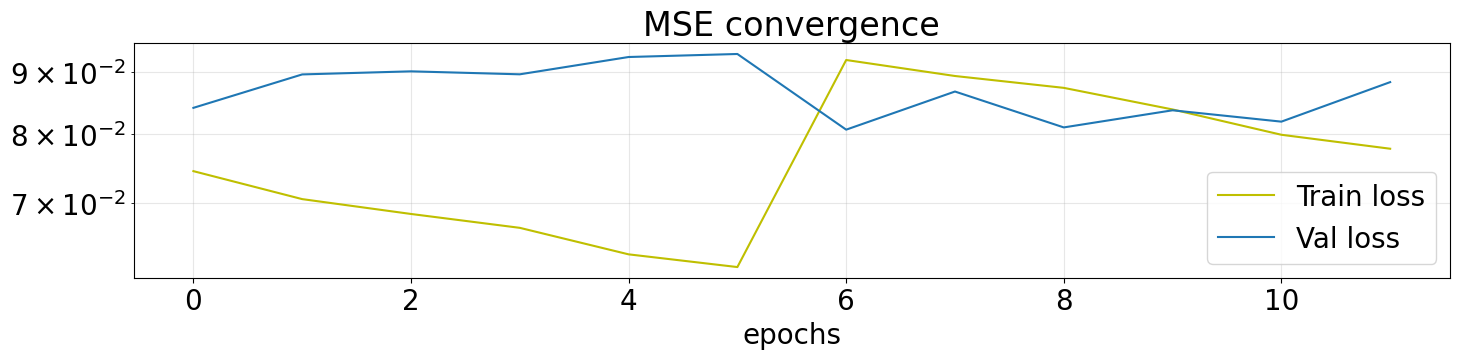

Epochs:  14%|█▍        | 7/50 [01:59<11:46, 16.43s/it]

Epoch 6 ; Train_Loss 0.0624 ; Val_Loss 0.0893 ; Ratio 1.4314
Time per epoch 15.00 seconds



Epochs:  16%|█▌        | 8/50 [02:12<10:50, 15.49s/it]

LOADING MINIMUM
LEARNING RATE CHANGE 0.0015
Epoch 7 ; Train_Loss 0.0593 ; Val_Loss 0.0865 ; Ratio 1.4576
Time per epoch 13.46 seconds



Epochs:  18%|█▊        | 9/50 [02:26<10:09, 14.86s/it]

Saving Model..
Epoch 8 ; Train_Loss 0.0884 ; Val_Loss 0.0811 ; Ratio 0.9172
Time per epoch 13.48 seconds

LOADING MINIMUM
LEARNING RATE CHANGE 0.001125
Saving Model..


Epochs:  20%|██        | 10/50 [02:39<09:37, 14.43s/it]

Epoch 9 ; Train_Loss 0.0859 ; Val_Loss 0.0835 ; Ratio 0.9717
Time per epoch 13.46 seconds

Saving Model..
Epoch 10 ; Train_Loss 0.0854 ; Val_Loss 0.0796 ; Ratio 0.9322
Time per epoch 13.16 seconds



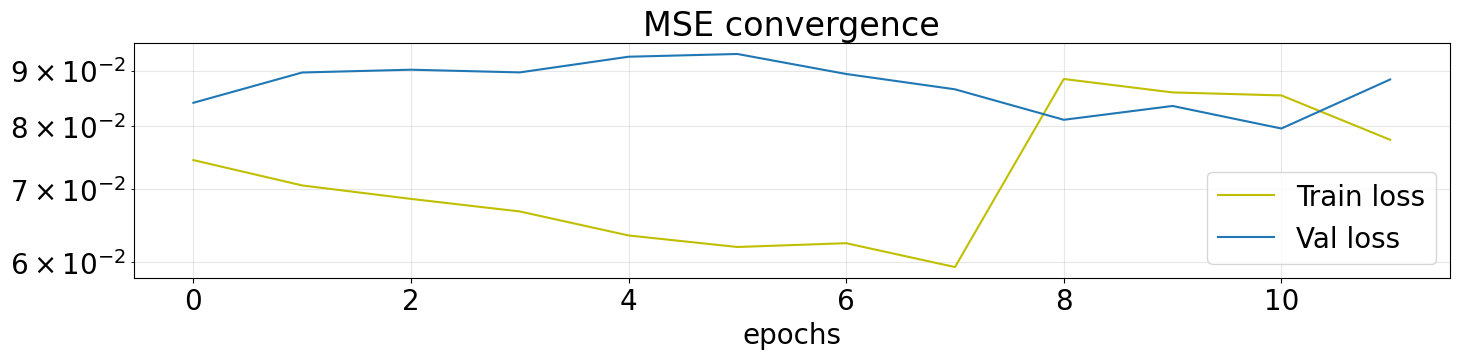

Epochs:  24%|██▍       | 12/50 [03:06<08:46, 13.86s/it]

Saving Model..
Epoch 11 ; Train_Loss 0.0832 ; Val_Loss 0.0794 ; Ratio 0.9543
Time per epoch 13.50 seconds



Epochs:  26%|██▌       | 13/50 [03:19<08:22, 13.59s/it]

Epoch 12 ; Train_Loss 0.0812 ; Val_Loss 0.0805 ; Ratio 0.9910
Time per epoch 12.96 seconds



Epochs:  28%|██▊       | 14/50 [03:32<08:05, 13.50s/it]

Epoch 13 ; Train_Loss 0.0792 ; Val_Loss 0.0823 ; Ratio 1.0386
Time per epoch 13.28 seconds



Epochs:  30%|███       | 15/50 [03:45<07:50, 13.45s/it]

Epoch 14 ; Train_Loss 0.0773 ; Val_Loss 0.0826 ; Ratio 1.0683
Time per epoch 13.34 seconds

Epoch 15 ; Train_Loss 0.0761 ; Val_Loss 0.0838 ; Ratio 1.1007
Time per epoch 13.15 seconds



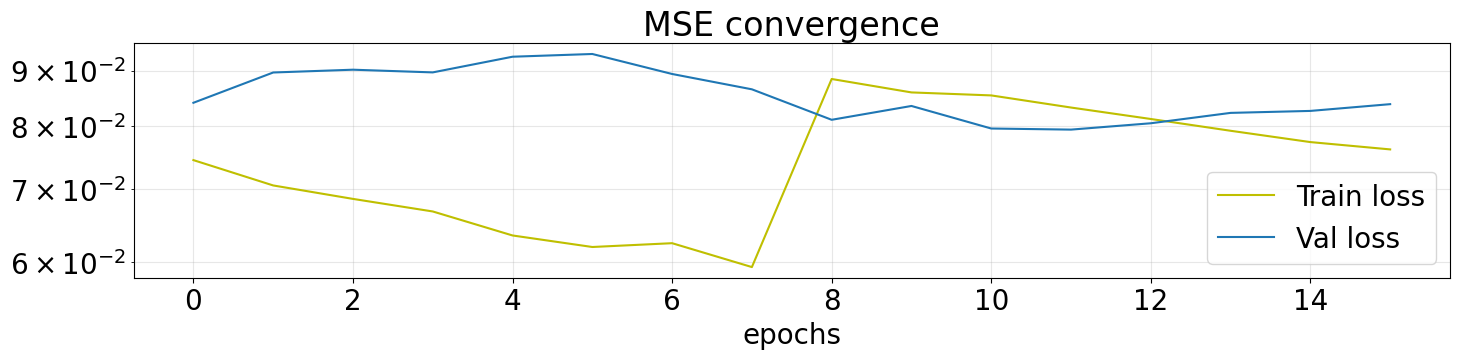

Epochs:  34%|███▍      | 17/50 [04:12<07:22, 13.41s/it]

Epoch 16 ; Train_Loss 0.0741 ; Val_Loss 0.0837 ; Ratio 1.1306
Time per epoch 13.60 seconds



Epochs:  36%|███▌      | 18/50 [04:25<07:08, 13.40s/it]

Epoch 17 ; Train_Loss 0.0715 ; Val_Loss 0.0876 ; Ratio 1.2258
Time per epoch 13.37 seconds



Epochs:  38%|███▊      | 19/50 [04:39<06:58, 13.50s/it]

Epoch 18 ; Train_Loss 0.0692 ; Val_Loss 0.0858 ; Ratio 1.2402
Time per epoch 13.73 seconds



Epochs:  40%|████      | 20/50 [04:53<06:47, 13.60s/it]

Epoch 19 ; Train_Loss 0.0671 ; Val_Loss 0.0898 ; Ratio 1.3400
Time per epoch 13.83 seconds

Epoch 20 ; Train_Loss 0.0651 ; Val_Loss 0.0883 ; Ratio 1.3563
Time per epoch 14.03 seconds



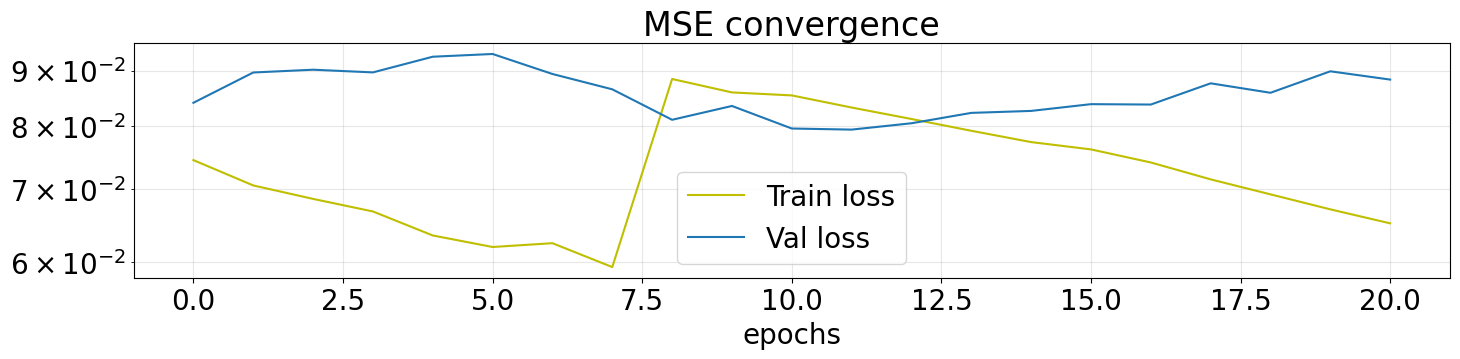

Epochs:  44%|████▍     | 22/50 [05:21<06:23, 13.69s/it]

Epoch 21 ; Train_Loss 0.0627 ; Val_Loss 0.0881 ; Ratio 1.4057
Time per epoch 13.65 seconds



Epochs:  46%|████▌     | 23/50 [05:34<06:06, 13.57s/it]

Epoch 22 ; Train_Loss 0.0621 ; Val_Loss 0.0858 ; Ratio 1.3821
Time per epoch 13.29 seconds



Epochs:  48%|████▊     | 24/50 [05:47<05:49, 13.44s/it]

Epoch 23 ; Train_Loss 0.0604 ; Val_Loss 0.0878 ; Ratio 1.4535
Time per epoch 13.14 seconds



Epochs:  50%|█████     | 25/50 [06:00<05:35, 13.42s/it]

Epoch 24 ; Train_Loss 0.0579 ; Val_Loss 0.0913 ; Ratio 1.5782
Time per epoch 13.37 seconds

Epoch 25 ; Train_Loss 0.0561 ; Val_Loss 0.0903 ; Ratio 1.6079
Time per epoch 13.43 seconds



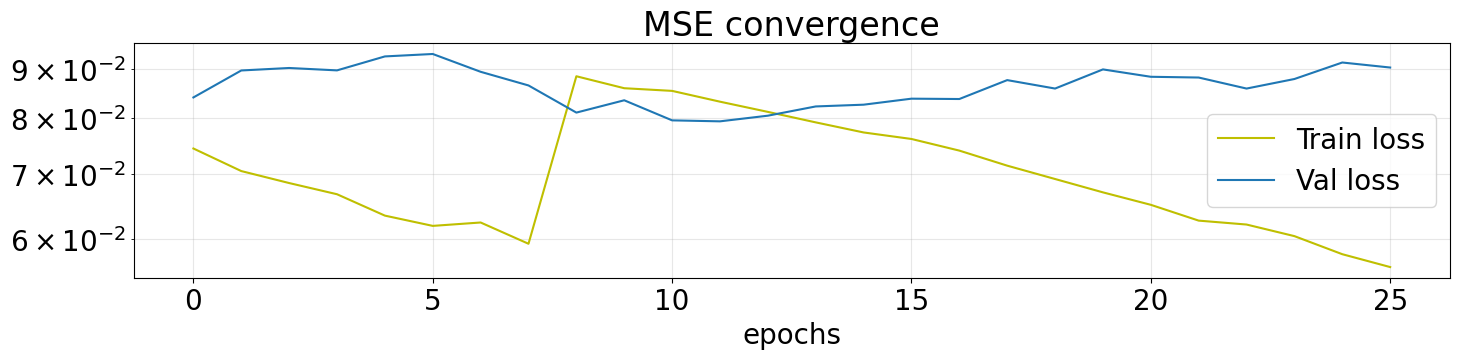

Epochs:  54%|█████▍    | 27/50 [06:27<05:09, 13.44s/it]

Epoch 26 ; Train_Loss 0.0550 ; Val_Loss 0.0898 ; Ratio 1.6322
Time per epoch 13.53 seconds



Epochs:  56%|█████▌    | 28/50 [06:41<04:54, 13.37s/it]

Epoch 27 ; Train_Loss 0.0528 ; Val_Loss 0.0882 ; Ratio 1.6700
Time per epoch 13.21 seconds



Epochs:  58%|█████▊    | 29/50 [06:54<04:41, 13.39s/it]

Epoch 28 ; Train_Loss 0.0532 ; Val_Loss 0.0856 ; Ratio 1.6091
Time per epoch 13.45 seconds



Epochs:  60%|██████    | 30/50 [07:07<04:28, 13.42s/it]

LOADING MINIMUM
LEARNING RATE CHANGE 0.00084374996
Epoch 29 ; Train_Loss 0.0509 ; Val_Loss 0.0849 ; Ratio 1.6675
Time per epoch 13.47 seconds

Epoch 30 ; Train_Loss 0.0815 ; Val_Loss 0.0804 ; Ratio 0.9870
Time per epoch 13.73 seconds



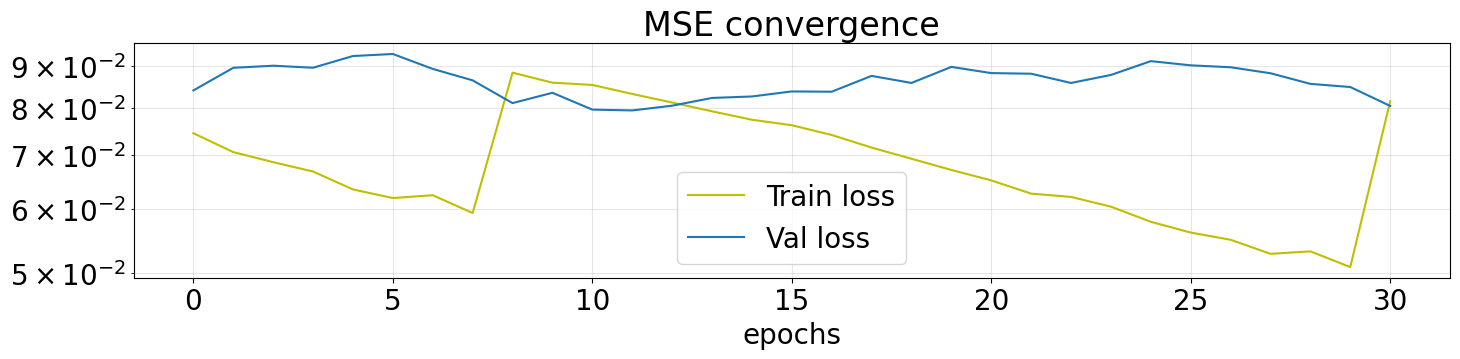

Epochs:  64%|██████▍   | 32/50 [07:35<04:03, 13.54s/it]

LOADING MINIMUM
LEARNING RATE CHANGE 0.0006328125
Epoch 31 ; Train_Loss 0.0797 ; Val_Loss 0.0819 ; Ratio 1.0277
Time per epoch 13.67 seconds



Epochs:  66%|██████▌   | 33/50 [07:48<03:50, 13.54s/it]

Epoch 32 ; Train_Loss 0.0813 ; Val_Loss 0.0808 ; Ratio 0.9934
Time per epoch 13.53 seconds



Epochs:  68%|██████▊   | 34/50 [08:02<03:36, 13.53s/it]

LOADING MINIMUM
LEARNING RATE CHANGE 0.00047460938
Epoch 33 ; Train_Loss 0.0795 ; Val_Loss 0.0812 ; Ratio 1.0216
Time per epoch 13.50 seconds



Epochs:  70%|███████   | 35/50 [08:15<03:22, 13.47s/it]

Epoch 34 ; Train_Loss 0.0809 ; Val_Loss 0.0814 ; Ratio 1.0061
Time per epoch 13.33 seconds

LOADING MINIMUM
LEARNING RATE CHANGE 0.00035595702
Epoch 35 ; Train_Loss 0.0797 ; Val_Loss 0.0821 ; Ratio 1.0300
Time per epoch 13.90 seconds



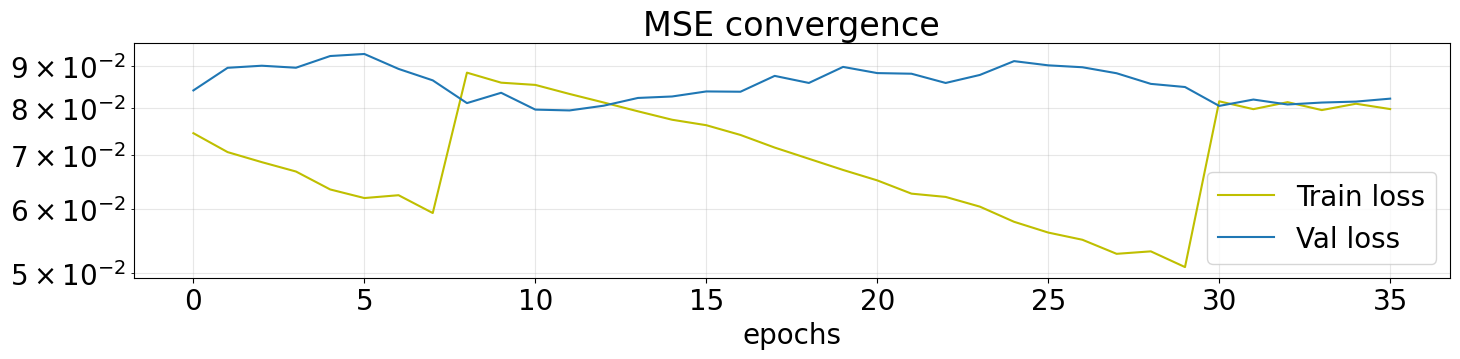

Epochs:  74%|███████▍  | 37/50 [08:43<02:57, 13.63s/it]

Epoch 36 ; Train_Loss 0.0810 ; Val_Loss 0.0806 ; Ratio 0.9952
Time per epoch 13.74 seconds



Epochs:  76%|███████▌  | 38/50 [08:57<02:44, 13.75s/it]

LOADING MINIMUM
LEARNING RATE CHANGE 0.00026696775
Epoch 37 ; Train_Loss 0.0800 ; Val_Loss 0.0805 ; Ratio 1.0060
Time per epoch 14.03 seconds



Epochs:  78%|███████▊  | 39/50 [09:10<02:29, 13.62s/it]

Epoch 38 ; Train_Loss 0.0810 ; Val_Loss 0.0804 ; Ratio 0.9927
Time per epoch 13.34 seconds



Epochs:  80%|████████  | 40/50 [09:24<02:15, 13.57s/it]

LOADING MINIMUM
LEARNING RATE CHANGE 0.00020022581
Epoch 39 ; Train_Loss 0.0800 ; Val_Loss 0.0808 ; Ratio 1.0101
Time per epoch 13.46 seconds

Epoch 40 ; Train_Loss 0.0808 ; Val_Loss 0.0808 ; Ratio 1.0002
Time per epoch 13.67 seconds



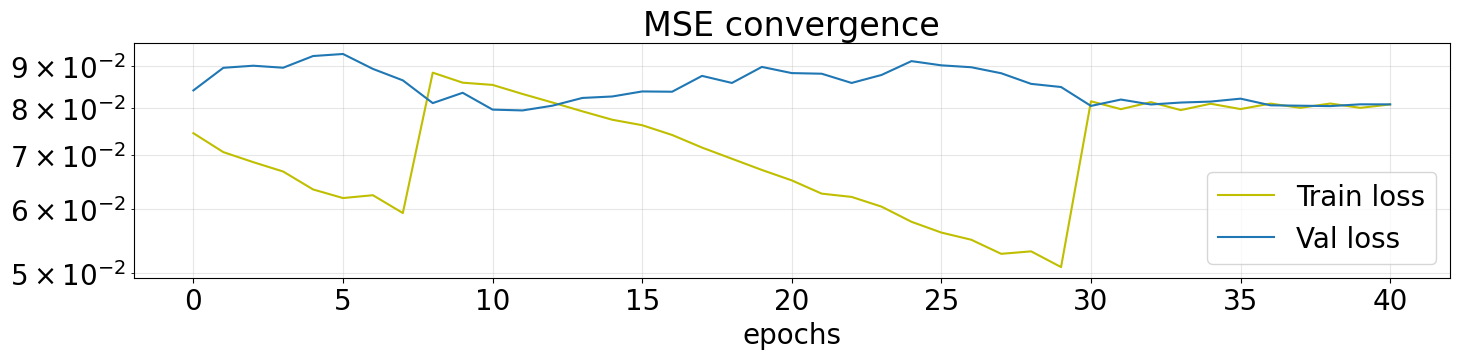

Epochs:  82%|████████▏ | 41/50 [09:41<02:07, 14.18s/it]


KeyboardInterrupt: 

In [66]:
from tqdm import trange, tqdm_notebook

t = time.time()  # Initialize time for printing time per epoch 
model_path = './data/48_RE30_'+str(N_lat) # to save model

for epoch in trange(n_epochs, desc='Epochs'):
    
    # Incorporate early stopping
    if epoch - last_save > patience:
        print('Early stopping')
        break
                
    # Perform gradient descent for all the batches every epoch
    loss_0 = 0
    rng.shuffle(U_train, axis=0) # shuffle batches
    for j in range(train_batches):
        loss    = train_step(U_train[j], enc_mods, dec_mods, Loss_Mse, optimizer)
        loss_0 += loss
    
    # save train loss
    tloss_plot[epoch]  = loss_0.numpy()/train_batches
    
    # every N epochs checks the convergence of the training loss and val loss
    if (epoch%N_check==0):
        
        # Compute Validation Loss
        loss_val        = 0
        for j in range(val_batches):
            loss        = train_step(U_val[j], enc_mods, dec_mods, Loss_Mse, optimizer, train=False)
            loss_val   += loss
        
        # Save validation loss
        vloss_plot[epoch]  = loss_val.numpy()/val_batches 

        # Decreases the learning rate if the training loss is not going down with respect to 
        # N_lr epochs before
        if epoch > N_lr and lrate_update:
            #check if the training loss is smaller than the average training loss N_lr epochs ago
            tt_loss   = np.mean(tloss_plot[epoch-N_lr:epoch])
            if tt_loss > old_loss[epoch-N_lr]:
                #if it is larger, load optimal val loss weights and decrease learning rate
                load_model(model_path)

                optimizer.learning_rate = optimizer.learning_rate*lrate_mult
                min_weights = optimizer.get_weights() # RV - just added this line
                optimizer.set_weights(min_weights)
                print('LEARNING RATE CHANGE', optimizer.learning_rate.numpy())
                old_loss[epoch-N_lr:epoch] = 1e6 #so that l_rate is not changed for N_lr steps
        
        #store current loss
        old_loss[epoch] = tloss_plot[epoch].copy()
        
        # save best model (the one with minimum validation loss)
        if epoch > 1 and vloss_plot[epoch] < \
                         (vloss_plot[:epoch-1][np.nonzero(vloss_plot[:epoch-1])]).min():
        
            #saving the model weights
            save_model(model_path)

            #saving optimizer parameters
            save_optimizer_params(model_path, optimizer)
            
            last_save = epoch #store the last time the val loss has decreased for early stop

        # Print loss values and training time (per epoch)
        print('Epoch', epoch, '; Train_Loss', f"{tloss_plot[epoch]:.4f}", 
              '; Val_Loss', f"{vloss_plot[epoch]:.4f}",  '; Ratio', f"{(vloss_plot[epoch])/(tloss_plot[epoch]):.4f}")
        print(f'Time per epoch {(time.time()-t):.2f} seconds')
        print('')
        t = time.time()  # Reset time after each epoch

    if (epoch%N_plot==0) and epoch != 0: # Plot every N_plot epochs
        plot_training_curve()

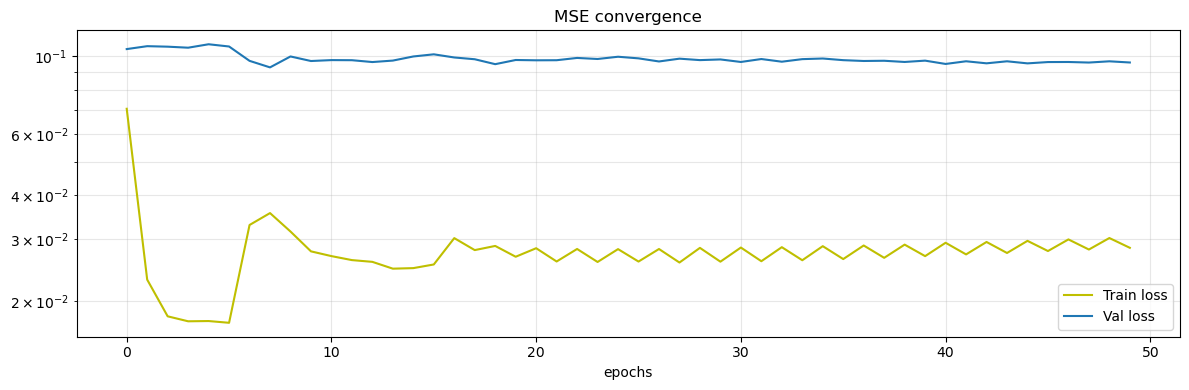

Plotting done


In [ ]:
# Set figure size
plt.figure(figsize=(12, 4))  # Width = 6 inches, Height = 4 inches

plt.title('MSE convergence')
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.plot(tloss_plot[np.nonzero(tloss_plot)], 'y', label='Train loss')
plt.plot(np.arange(np.nonzero(vloss_plot)[0].shape[0]) * N_check, vloss_plot[np.nonzero(vloss_plot)], label='Val loss')
plt.xlabel('epochs')
plt.legend()    
plt.tight_layout()
plt.show()

print("Plotting done")

# Compute the error over the test set

In [ ]:
# Compute the NRMSE for the test data by comparing the encoded data and the ground truth data
def compute_nrmse(U_test, U_pred):
    """
    Compute the Normalized Root-Mean-Square Error (NRMSE) for batched flowfields.
    
    Args:
        U_test: Tensor of shape [batch_size, 48, 48, 2], the ground truth flowfield.
        U_pred: Tensor of shape [batch_size, 48, 48, 2], the predicted (reconstructed) flowfield.

    Returns:
        nrmse: A scalar Tensor, the computed NRMSE across all batches.
    """

    # Compute the mean squared error (MSE) for each batch
    mse = tf.reduce_mean(tf.square(U_pred - U_test), axis=[1, 2, 3])  # Shape: [batch_size]

    # Compute the variance of the ground truth (σ²) for normalization
    variance = tf.reduce_mean(tf.square(U_test - tf.reduce_mean(U_test, axis=[1, 2, 3], keepdims=True)), axis=[1, 2, 3])

    # Compute the NRMSE for each batch
    nrmse_per_batch = tf.sqrt(mse / variance)  # Shape: [batch_size]

    # Average NRMSE across the batch
    nrmse = tf.reduce_mean(nrmse_per_batch)

    return nrmse

for i in range(test_batches):
    U_pred = model(U_test[i], enc_mods, dec_mods)[-1]

nrmse = compute_nrmse(U_test, U_pred)
print("NRMSE:", nrmse.numpy())

NRMSE: 0.3690324


# Visualize error

In [40]:
#load model for the test set
path = './data/48_RE30_'+str(N_lat)
os.makedirs(path, exist_ok=True)

enc_mods_test = [None] * N_parallel
dec_mods_test = [None] * N_parallel

for i in range(N_parallel):
    enc_path = f"{path}/enc_mod{ker_size[i]}_{N_lat}.h5"
    dec_path = f"{path}/dec_mod{ker_size[i]}_{N_lat}.h5"
    print(f"Loading models: encoder -> {enc_path}, decoder -> {dec_path}")

    if os.path.exists(enc_path) and os.path.exists(dec_path):
        try:
            enc_mods_test[i] = tf.keras.models.load_model(enc_path, custom_objects={"PerPad2D": PerPad2D})
            dec_mods_test[i] = tf.keras.models.load_model(dec_path, custom_objects={"PerPad2D": PerPad2D})
        except Exception as e:
            raise RuntimeError(f"Error loading models: {e}")
    else:
        raise FileNotFoundError(f"Model files not found: {enc_path}, {dec_path}")


Loading models: encoder -> ./data/48_RE30_5/enc_mod(3, 3)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(3, 3)_5.h5
Loading models: encoder -> ./data/48_RE30_5/enc_mod(5, 5)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(5, 5)_5.h5
Loading models: encoder -> ./data/48_RE30_5/enc_mod(7, 7)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(7, 7)_5.h5


0


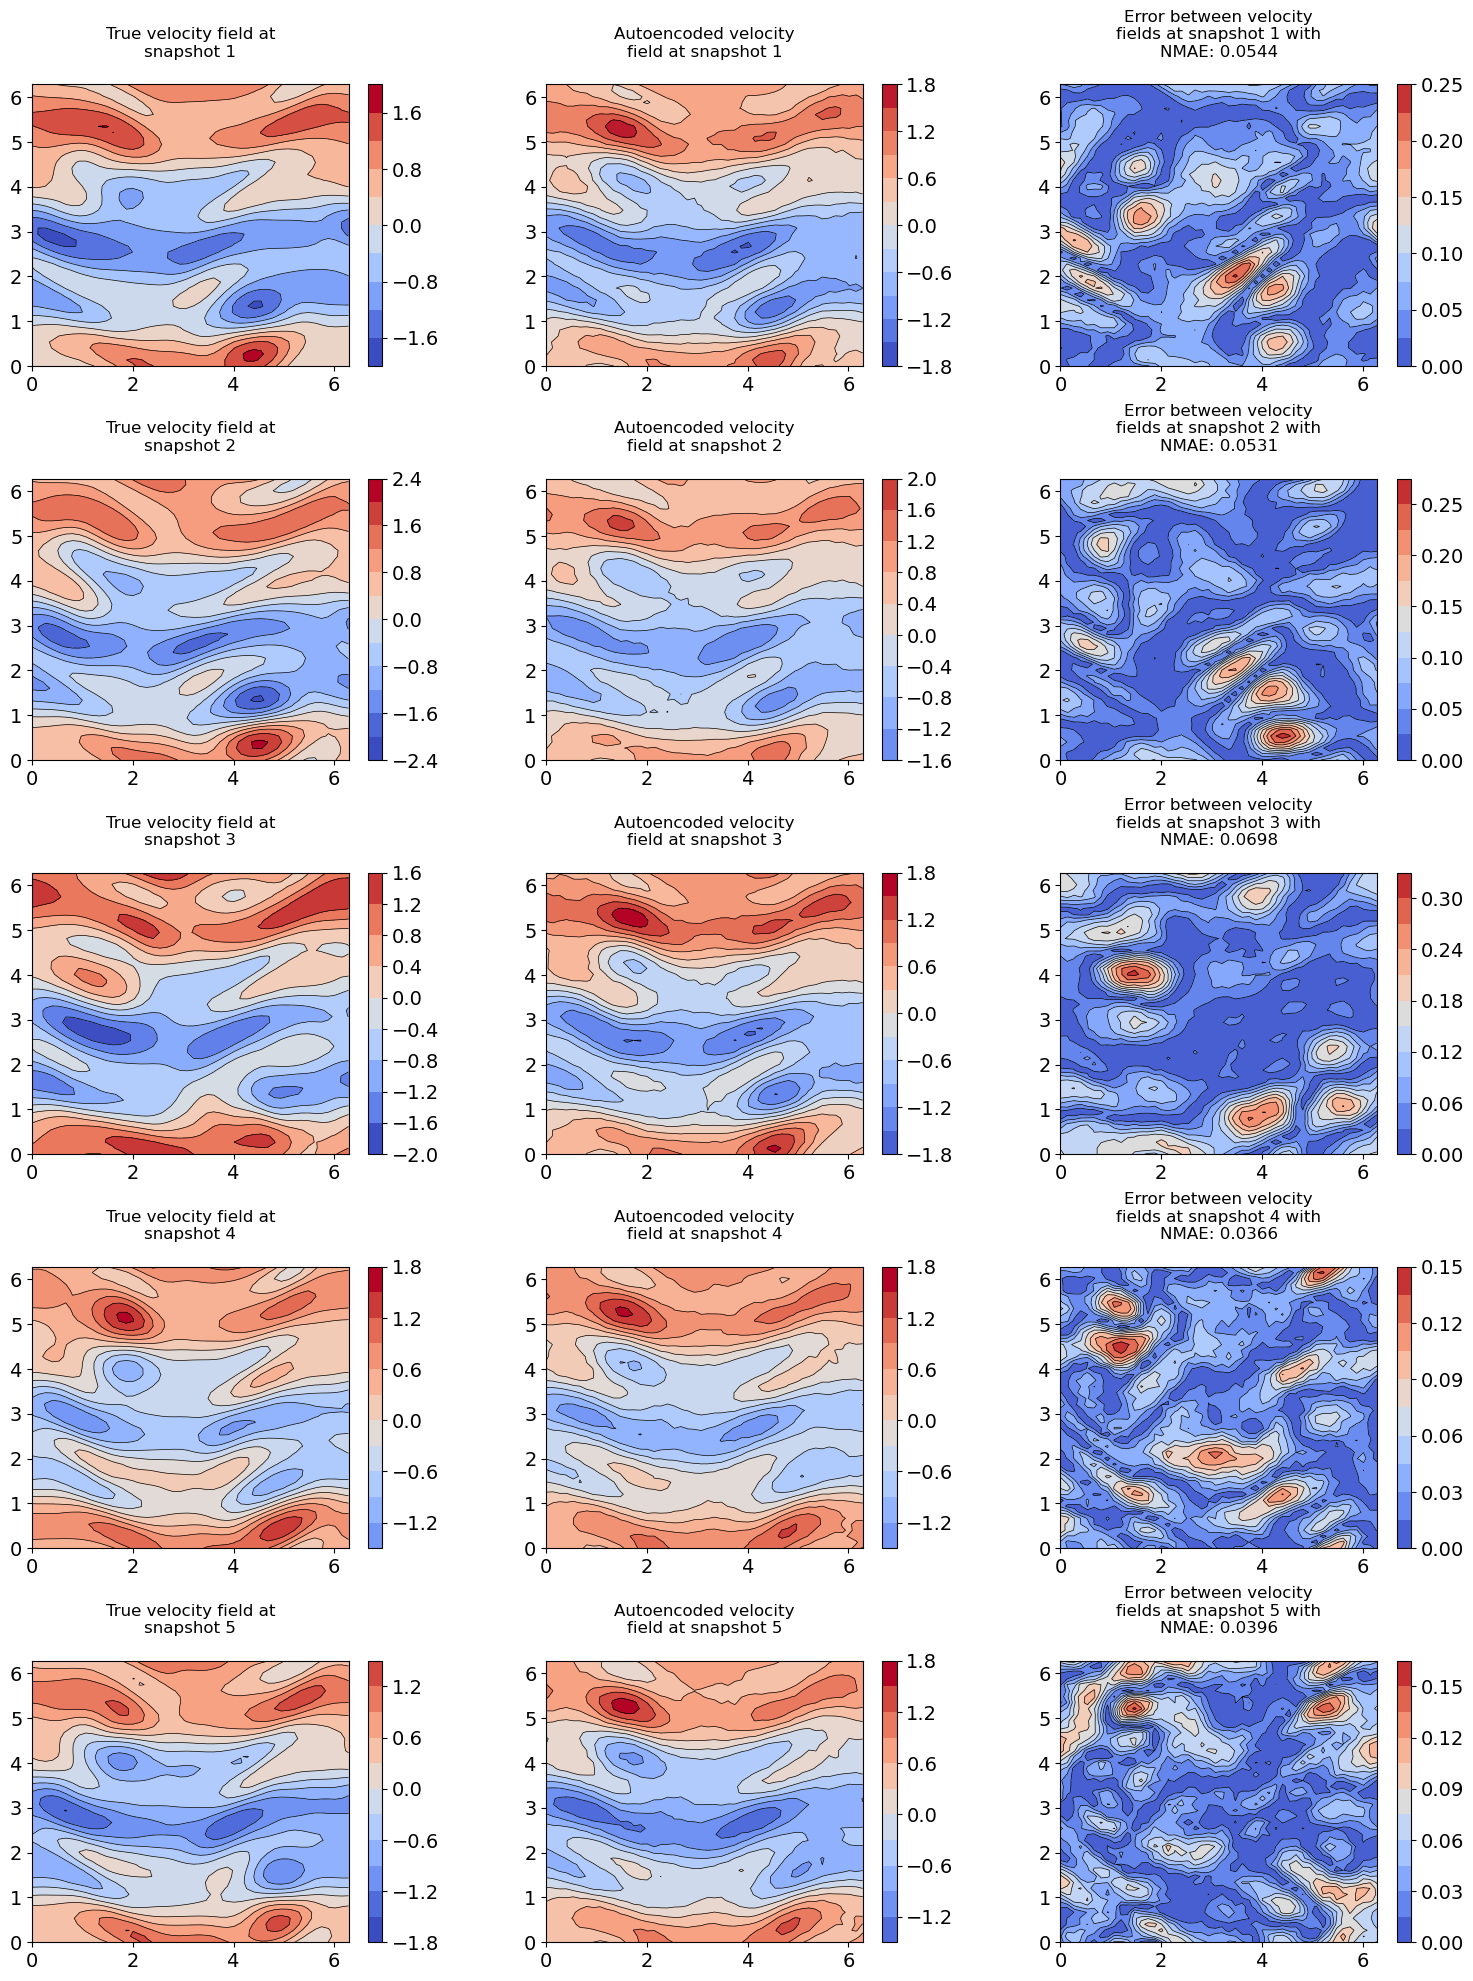

In [43]:
import textwrap

# grid
X = np.linspace(0, 2 * np.pi, N_x) 
Y = np.linspace(0, 2 * np.pi, N_y) 
XX = np.meshgrid(X, Y, indexing='ij')

# plot n snapshots and their reconstruction in the test set.
n_snapshots = 5
plt.rcParams["figure.figsize"] = (15, 4 * n_snapshots)
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(n_snapshots, 3)

# start after validation set
start = 0 # b_size * n_batches * downsample + b_size * val_batches * downsample
print(start)

# Function to wrap text
def wrap_text(text, width=25):
    return "\n".join(textwrap.wrap(text, width))

for i in range(n_snapshots):
    # testing data
    skips = 10
    # u = U_test_unbatched[i*100:i*100+1].copy()
    u      = U_test_unbatched[start+10+i*skips:start+11+i*skips].copy() 
    vmax = u.max()
    vmin = u.min()
    
    # truth
    ax_truth = plt.subplot(n_snapshots, 3, i * 3 + 1)
    CS0 = ax_truth.contourf(XX[0], XX[1], u[0, :, :, 0],
                            levels=10, cmap='coolwarm', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(CS0, ax=ax_truth)
    CS = ax_truth.contour(XX[0], XX[1], u[0, :, :, 0],
                          levels=10, colors='black', linewidths=.5, linestyles='solid',
                          vmin=vmin, vmax=vmax)
    title = wrap_text(f'True velocity field at snapshot {i+1}')
    ax_truth.set_title(title, pad=20, fontsize=12)

    # autoencoded
    ax_auto = plt.subplot(n_snapshots, 3, i * 3 + 2)
    u_dec = model(u, enc_mods_test, dec_mods_test)[1][0].numpy()
    CS = ax_auto.contourf(XX[0], XX[1], u_dec[:, :, 0],
                          levels=10, cmap='coolwarm', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(CS, ax=ax_auto)
    CS = ax_auto.contour(XX[0], XX[1], u_dec[:, :, 0],
                         levels=10, colors='black', linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    title = wrap_text(f'Autoencoded velocity field at snapshot {i+1}')
    ax_auto.set_title(title, pad=20, fontsize=12)
    
    # error
    ax_err = plt.subplot(n_snapshots, 3, i * 3 + 3)
    u_err = np.abs(u_dec - u[0]) / (vmax - vmin)
    nmae = u_err[:, :, 0].mean()

    CS = ax_err.contourf(XX[0], XX[1], u_err[:, :, 0], levels=10, cmap='coolwarm')
    cbar = plt.colorbar(CS, ax=ax_err)
    CS = ax_err.contour(XX[0], XX[1], u_err[:, :, 0], levels=10, colors='black', linewidths=.5,
                        linestyles='solid')
    title = wrap_text(f'Error between velocity fields at snapshot {i+1} with NMAE: {nmae:.4f}')
    ax_err.set_title(title, pad=20, fontsize=12)
    
# Adjust spacing between plots
fig.tight_layout(pad=1.0)  # Increase the padding between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Add extra spacing between rows and columns

plt.savefig(path + '/Autoencoder_error.pdf')
plt.show()

# Save Encoded Data

In [25]:
a = [None]*N_parallel
b = [None]*N_parallel

for i in range(N_parallel):
    a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5', 
                                            custom_objects={"PerPad2D": PerPad2D})
    
for i in range(N_parallel):
    b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5', 
                                            custom_objects={"PerPad2D": PerPad2D})

U_enc = np.zeros((500, N_lat))

for i in range(500):
    U_enc[i] = model(U[i:i+1], a, b)[0].numpy().flatten()

fln = './data/48_Encoded_data_Re30_' + str(N_lat) +'.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('U_enc',data=U_enc)  
hf.close()
print(fln)

./data/48_Encoded_data_Re30_5.h5


# Decoder

In [26]:
def batch_encoded(U_enc, b_size, n_batches):
    data = np.zeros((n_batches, b_size, U_enc.shape[1]))    
    for i in range(n_batches):
        data[i] = U_enc[i*b_size: (i+1)*b_size].copy()
    return data

In [27]:
U_enct = np.array(U_enc.copy())

batch_size = 10

n_batch = len(U_enc) // batch_size
U_enc_test = batch_encoded(U_enct, batch_size, n_batch)

In [28]:
def dec_model(encoded, dec_mods):
    
    '''
    This is only the decoder module
    '''
        
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=False)
        
    return decoded

In [ ]:
load_decs = [None]*N_parallel

for i in range(N_parallel):
    load_decs[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5', 
                                            custom_objects={"PerPad2D": PerPad2D})

U_dec = np.zeros((n_batch, batch_size, 48, 48, 2))

for i, batch in enumerate(U_enc_test):
    U_dec[i] = dec_model(batch, load_decs)

dec_file = './data/48_Decoded_data_Re30_' + str(N_lat) +'.h5'
hf = h5py.File(dec_file,'w')
hf.create_dataset('U_dec',data=U_dec)  
hf.close()
print(dec_file)

KeyboardInterrupt: 